# Project 1 Step 6 Match Return And Plot Figure 1
In this notebook, we will do the following:
- Load in the negative words proportions calculated for each document in the last step
- Use its ticker and filing date to find the 4-day buy-and-hold excess stock returns in the return csv file we prepared in step 4
- Split all negative word proportions into 5 portfolios according to the level of negative word proportions
- Replicate figure 1 using current data we have

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")

from datetime import date
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing

from bs4 import BeautifulSoup
import re
from pathlib import Path
import json

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer  # for bag-of-words method
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF method

import matplotlib.pyplot as plt

In [3]:
data_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/"
data_path_10q = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/10Q/"
data_path_10k = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/10K/"

cik_lookup_filename = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/CIK_lookup_results_cleaned.csv"
sp500_constituents_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/sp500_constituents.csv"
sp500_id_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/sp500_w_addl_id.csv"

index_return_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/Index_Returns.csv"
stock_return_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/Stock_Prices.csv"
buyhold_excess_return_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/Stock_Excess_BuyHoldReturn.csv"

word_list_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/WordLists"
H4N_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/Dictionary/Harvard IV_Negative Word List_Inf.txt"
FinNeg_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/Dictionary/Loughran-McDonald_MasterDictionary_1993-2021.csv"
neg_prop_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/NegWordProportions"
results_path = "/content/drive/MyDrive/Mini 5/Natural Language Processing/Project 1/data/Results"

#### Load in 4-day Buy-and-Hold Stock Excess Return Data from Step 4

In [4]:
excess_return = pd.read_csv(buyhold_excess_return_path)
excess_return

,date,TICKER,BuyHoldRet_excess
0,20110103,ORCL,-0.013902
1,20110104,ORCL,-0.015287
2,20110105,ORCL,-0.013835
3,20110106,ORCL,-0.001212
4,20110107,ORCL,-0.018513
...,...,...,...
1860802,20211227,TSLA,-0.005754
1860803,20211228,TSLA,-0.028507
1860804,20211229,TSLA,-0.035978
1860805,20211230,TSLA,-0.043188


In [5]:
excess_return['date'] = excess_return['date'].apply(lambda x: str(x))
excess_return

,date,TICKER,BuyHoldRet_excess
0,20110103,ORCL,-0.013902
1,20110104,ORCL,-0.015287
2,20110105,ORCL,-0.013835
3,20110106,ORCL,-0.001212
4,20110107,ORCL,-0.018513
...,...,...,...
1860802,20211227,TSLA,-0.005754
1860803,20211228,TSLA,-0.028507
1860804,20211229,TSLA,-0.035978
1860805,20211230,TSLA,-0.043188


#### Load in csv file from Step 5 (TFIDF) and Match Excess Returns Using Ticker and Filing Date

In [6]:
def neg_proportion_match_return(neg_prop_file, excess_return):
  """
  Read in csv files with negative proportions. Use ticker and filing date to match corresponding 4-day buy-and-hold excess stock return.
  Make result a dataframe. We will concatenate all this kind of dataframes in the next function.
  """
  # read in csv negative proportion data in step 5
    neg_prop_df = pd.read_csv(neg_prop_file)

  # merge the negative proportion calculated using TFIDF measure and the excess stock return
    result_df = neg_prop_df.merge(excess_return, left_on=['ticker', 'filing_date'], right_on=['TICKER', 'date'], how='inner')
    return result_df

In [7]:
neg_prop_harvard_path = os.path.join(neg_prop_path, "Neg_Prop_Result_harvard.csv")
neg_prop_finneg_path = os.path.join(neg_prop_path, "Neg_Prop_Result_finneg.csv")
match_return_df_harvard = neg_proportion_match_return(neg_prop_harvard_path, excess_return)
match_return_df_finneg = neg_proportion_match_return(neg_prop_finneg_path, excess_return)

In [8]:
match_return_df_harvard

,ticker,filing_date,NegProp_TFIDF,date,TICKER,BuyHoldRet_excess
0,EBAY,20180205,0.020145,20180205,EBAY,-0.012617
1,EBAY,20190130,0.019511,20190130,EBAY,0.009646
2,EBAY,20200131,0.018508,20200131,EBAY,0.044372
3,EBAY,20210204,0.016592,20210204,EBAY,0.044166
4,DFS,20200226,0.018404,20200226,DFS,-0.006581
...,...,...,...,...,...,...
9221,ZTS,20200806,0.014504,20200806,ZTS,-0.004230
9222,ZTS,20201105,0.017124,20201105,ZTS,-0.098487
9223,ZTS,20210506,0.016129,20210506,ZTS,-0.015032
9224,ZTS,20210805,0.015863,20210805,ZTS,-0.037460


In [9]:
match_return_df_finneg

,ticker,filing_date,NegProp_TFIDF,date,TICKER,BuyHoldRet_excess
0,EBAY,20180205,0.006369,20180205,EBAY,-0.012617
1,EBAY,20190130,0.005972,20190130,EBAY,0.009646
2,EBAY,20200131,0.006323,20200131,EBAY,0.044372
3,EBAY,20210204,0.006262,20210204,EBAY,0.044166
4,DFS,20200226,0.004902,20200226,DFS,-0.006581
...,...,...,...,...,...,...
9221,ZTS,20200806,0.003906,20200806,ZTS,-0.004230
9222,ZTS,20201105,0.004005,20201105,ZTS,-0.098487
9223,ZTS,20210506,0.004435,20210506,ZTS,-0.015032
9224,ZTS,20210805,0.004670,20210805,ZTS,-0.037460


This function first sorts input_df according to level of negative word proportion in ascending order. 
Then we will split all entries into 5 different portfolios. 
We then use groupby to calculate the median filing period excess returns for these 5 portfolios. 
<br>Finally we can replicate Figure 1 from the paper.

In [12]:
def divide_five_portfolios(input_df):
  """
  This function first sorts input_df according to level of negative word proportion in ascending order. Then we will 
  split all entries into 5 different portfolios. We then use groupby to calculate the median filing period excess returns
  for these 5 portfolios. Finally we can replicate Figure 1 from the paper.
  """
    sorted_input_df = input_df.sort_values(by='NegProp_TFIDF')
    sorted_input_df = sorted_input_df.reset_index(drop=True, inplace=False)
    df_length = sorted_input_df.shape[0]
    begin_index = [i * (df_length // 5) for i in list(range(5))]
    end_index = begin_index[1:]
    end_index.append(df_length)
    portfolio_assignment_list = np.array(list(range(df_length)))
    label = 1
    for i, j in zip(begin_index, end_index):
    # print(i, j)
        portfolio_assignment_list[i:j] = label
        label += 1
    sorted_input_df['portfolio_label'] = portfolio_assignment_list
    return sorted_input_df

In [13]:
sorted_df_harvard = divide_five_portfolios(match_return_df_harvard)

In [14]:
sorted_df_finneg = divide_five_portfolios(match_return_df_finneg)

In [15]:
sorted_df_harvard

,ticker,filing_date,NegProp_TFIDF,date,TICKER,BuyHoldRet_excess,portfolio_label
0,VMC,20200805,0.000493,20200805,VMC,0.047370,1
1,VMC,20201106,0.000500,20201106,VMC,0.012498,1
2,PNC,20160803,0.000506,20160803,PNC,0.046333,1
3,PNC,20170802,0.000557,20170802,PNC,0.005540,1
4,SBAC,20210805,0.000564,20210805,SBAC,-0.030274,1
...,...,...,...,...,...,...,...
9221,TSLA,20210428,0.048485,20210428,TSLA,-0.025635,5
9222,NLSN,20131023,0.048505,20131023,NLSN,0.000662,5
9223,GRMN,20210428,0.051696,20210428,GRMN,-0.020371,5
9224,PCG,20150429,0.057800,20150429,PCG,0.022992,5


In [16]:
sorted_df_finneg

,ticker,filing_date,NegProp_TFIDF,date,TICKER,BuyHoldRet_excess,portfolio_label
0,ETR,20141106,0.000000,20141106,ETR,-0.018099,1
1,DUK,20170509,0.000000,20170509,DUK,0.010057,1
2,DUK,20161104,0.000000,20161104,DUK,-0.043675,1
3,OI,20120426,0.000000,20120426,OI,-0.055561,1
4,EXC,20171102,0.000000,20171102,EXC,0.024793,1
...,...,...,...,...,...,...,...
9221,GRMN,20211027,0.041879,20211027,GRMN,-0.128415,5
9222,CLX,20150504,0.043700,20150504,CLX,0.017843,5
9223,GRMN,20210728,0.045898,20210728,GRMN,0.037946,5
9224,TSLA,20210428,0.048452,20210428,TSLA,-0.025635,5


portfolio_label in both plots represent for the group of each entry based on the level of negative word proportion. 

In [17]:
sorted_df_harvard.to_csv(os.path.join(results_path, "sorted_df_harvard_tfidf.csv"), index=False)
sorted_df_finneg.to_csv(os.path.join(results_path, "sorted_df_finneg_tfidf.csv"), index=False)

#### Use groupby to calculate the median filing period excess returns for these 5 portfolios. 

In [18]:
sorted_df_harvard.groupby("portfolio_label")['BuyHoldRet_excess'].median()

portfolio_label
1    0.000608
2    0.000083
3   -0.000380
4    0.000897
5   -0.000127
Name: BuyHoldRet_excess, dtype: float64

In [19]:
sorted_df_finneg.groupby("portfolio_label")['BuyHoldRet_excess'].median()

portfolio_label
1    0.000501
2    0.000279
3    0.000901
4   -0.000061
5   -0.000580
Name: BuyHoldRet_excess, dtype: float64

#### Replicate Figure 1 from the paper.

In [20]:
def figure_1_plotting(input_df_harvard, input_df_finneg):
    medians_harvard = input_df_harvard.groupby("portfolio_label")['BuyHoldRet_excess'].median().values
    medians_finneg = input_df_finneg.groupby("portfolio_label")['BuyHoldRet_excess'].median().values
    x_ax = [1, 2, 3, 4, 5]

    fig, ax = plt.subplots(1, 1, figsize=(15, 9))
    plt.plot(x_ax, medians_harvard, color='blue', label="H4N-Inf")
    plt.plot(x_ax, medians_finneg, color='orange', label="Fin-Neg")
    plt.legend(loc='upper right')
    plt.xlabel("Quintile (based on proportion of negative words calculated from TF-IDF measure)", fontsize=12)
    plt.ylabel("Median Filing Period Excess Return", fontsize=12)
    plt.title("Figure 1 based on TF-IDF measure", fontsize=14)
    plt.savefig(os.path.join(results_path, "Figure1_TFIDF.png"))
  # plt.show()

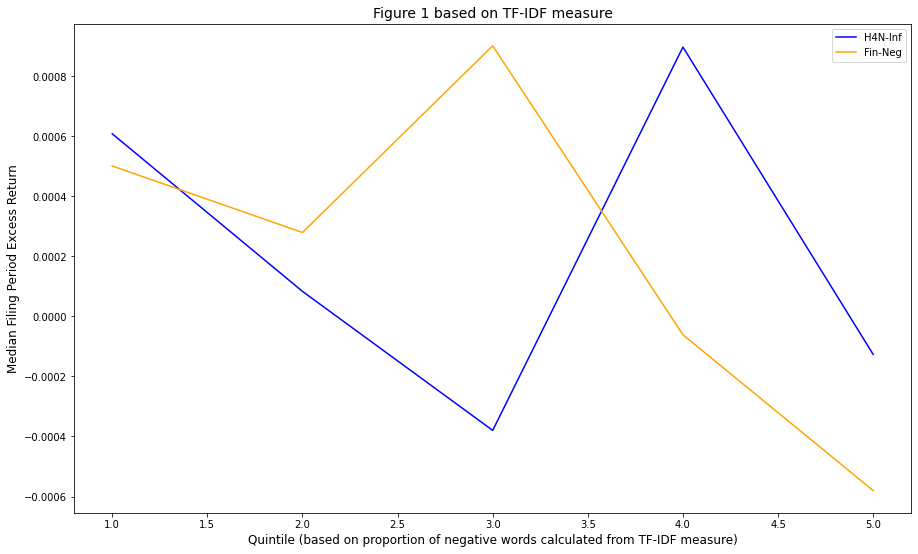

In [21]:
figure_1_plotting(sorted_df_harvard, sorted_df_finneg)